## Physics-Informed Neural Networks (PINNs) Practical Exercise
## Solving the 1D Heat Equation using PINNs

#### imports and installations

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set seed for reproducibility
torch.manual_seed(42)

## Configure system Parameters and Initial Conditions

In [90]:
alpha = 0.001       # original thermal diffusivity [m^2/s]
L     = 1.0        # domain length [m]
T_max = 1     # max time [s]
U_max = 1      # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

def system_params(alpha=alpha, L=L, T_max=T_max, U_max=U_max):
    return {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

system_params = system_params()

### Set up initial and boundary conditions configuration
#### Consider 2 optional IC setups- sinusoidal and block heat source

In [18]:
# create a sinusoidal distribution initial condition
def initial_condition_sin(x):
    u_initial = torch.sin(torch.pi * x) 
    return u_initial

# create a block heat source initial condition
def initial_condition_block(x, width = 0.2, center = 0.5, high_temp = 1.0, low_temp = 0.0):
    # Create mask for points inside the block
    mask = (x >= (center - width/2)) & (x <= (center + width/2))
    
    # Initialize with low temperature
    u_initial = torch.full_like(x, low_temp)
    
    # Set high temperature for points inside the block
    u_initial[mask] = high_temp
    
    return u_initial


def boundary_condition(x,t, boundary_value):
    return torch.full_like(x, boundary_value)

In [17]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

In [19]:
def generate_training_data(num_points):
    x = torch.rand(num_points, 1, requires_grad = True)
    t = torch.rand(num_points, 1, requires_grad = True)
    
    return x,t

In [20]:
def generate_boundary_training_data(num_points):
    # create x_boundary and t_boundary
    x_boundary_0 = torch.zeros(num_points//2, 1, requires_grad=True)  # x=0 boundary
    x_boundary_1 = torch.ones(num_points//2, 1, requires_grad=True)   # x=1 boundary
    x_boundary = torch.cat([x_boundary_0, x_boundary_1], dim=0)       # combine both boundaries
    t_boundary = torch.rand(num_points, 1, requires_grad=True)   # random time points
    
    return x_boundary, t_boundary

In [21]:
def pde(x,t,model):
    input_data = torch.cat([x,t],dim=1)
    u = model(input_data)
    alpha= 0.1

    u_x = torch.autograd.grad(u, x,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x,x,grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u,t,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    heat_eq_residual = alpha * u_xx - u_t
    return heat_eq_residual

In [79]:
def train_PINN(model, num_iterations, num_points,loss_weights = {'ic': 1, 'bc': 1, 'pde': 1},patience = 0.0001, print_loss = True):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ic_losses = []
    bc_losses = []
    pde_losses = []
    total_losses = []
    w_ic = loss_weights['ic']
    w_bc = loss_weights['bc']
    w_pde = loss_weights['pde']
    
    for  iteration in range(num_iterations):
        optimizer.zero_grad()
        
        x,t = generate_training_data(num_points)
        
        x_b,t_b = generate_boundary_training_data(num_points)
        
        t_intial = torch.zeros_like(t)
        u_intial = initial_condition_block(x,width = 0.5, center = 0.5, high_temp = 1.0, low_temp = 0.0)
        custom_value = 0
        u_boundary_x = boundary_condition(x_b,t_b,custom_value)
        
        residual = pde(x,t,model)
        
        ic_loss= nn.MSELoss()(u_intial, model(torch.cat([x,t_intial], dim=1))) * w_ic
        bc_loss = nn.MSELoss()(u_boundary_x, model(torch.cat([x_b,t_b], dim=1))) * w_bc
        pde_loss = nn.MSELoss()(residual, torch.zeros_like(residual)) * w_pde
        loss = ic_loss + bc_loss + pde_loss
        loss.backward()
        optimizer.step()

        # Accumulate losses
        ic_losses.append(ic_loss.item())
        bc_losses.append(bc_loss.item())
        pde_losses.append(pde_loss.item())
        total_losses.append(loss.item())

    
        # Print loss every 100 iterations and check for early stopping
        if iteration % 100 ==0:
            if print_loss:
                print("iteration", iteration, "total_loss", f"{loss.item():.3f}", "ic_loss", f"{ic_loss.item():.4f}", "bc_loss", f"{bc_loss.item():.4f}", "pde_loss", f"{pde_loss.item():.4f}")

            # Early stopping when the avrage loss over the last 10 iterations is not changing
            diff_losses = (np.mean(total_losses[-100:]) - np.mean(total_losses[-50:]))
            print("diff_losses", diff_losses)
            if iteration > 0 and diff_losses < patience:
                print("Early stopping at iteration", iteration)
                df = pd.DataFrame({'ic_loss': ic_losses, 'bc_loss': bc_losses, 'pde_loss': pde_losses, 'total_loss': total_losses})
                return df
            
            
    # insert all losses to a dataframe
    df = pd.DataFrame({'ic_loss': ic_losses, 'bc_loss': bc_losses, 'pde_loss': pde_losses, 'total_loss': total_losses})
    return df


In [37]:
def plot_losses(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['total_loss'], label='Total Loss')
    plt.plot(df['ic_loss'], label='IC Loss')
    plt.plot(df['bc_loss'], label='BC Loss')
    plt.plot(df['pde_loss'], label='PDE Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()


iteration 0 total_loss 0.937 ic_loss 0.6093 bc_loss 0.1692 pde_loss 0.1582
diff_losses 0.0
iteration 100 total_loss 0.464 ic_loss 0.4404 bc_loss 0.0218 pde_loss 0.0013
diff_losses 0.015361798405647276
iteration 200 total_loss 0.442 ic_loss 0.4185 bc_loss 0.0223 pde_loss 0.0011
diff_losses 0.004733965694904363
iteration 300 total_loss 0.432 ic_loss 0.4092 bc_loss 0.0191 pde_loss 0.0037
diff_losses 0.010720621645450623
iteration 400 total_loss 0.281 ic_loss 0.2440 bc_loss 0.0182 pde_loss 0.0188
diff_losses 0.03237790107727051
iteration 500 total_loss 0.190 ic_loss 0.1588 bc_loss 0.0224 pde_loss 0.0086
diff_losses 0.023729064017534274
iteration 600 total_loss 0.153 ic_loss 0.1261 bc_loss 0.0191 pde_loss 0.0079
diff_losses 0.008254895657300948
iteration 700 total_loss 0.136 ic_loss 0.1139 bc_loss 0.0109 pde_loss 0.0112
diff_losses 0.004438840150833151
iteration 800 total_loss 0.123 ic_loss 0.1072 bc_loss 0.0077 pde_loss 0.0079
diff_losses 0.003315619304776196
iteration 900 total_loss 0.138

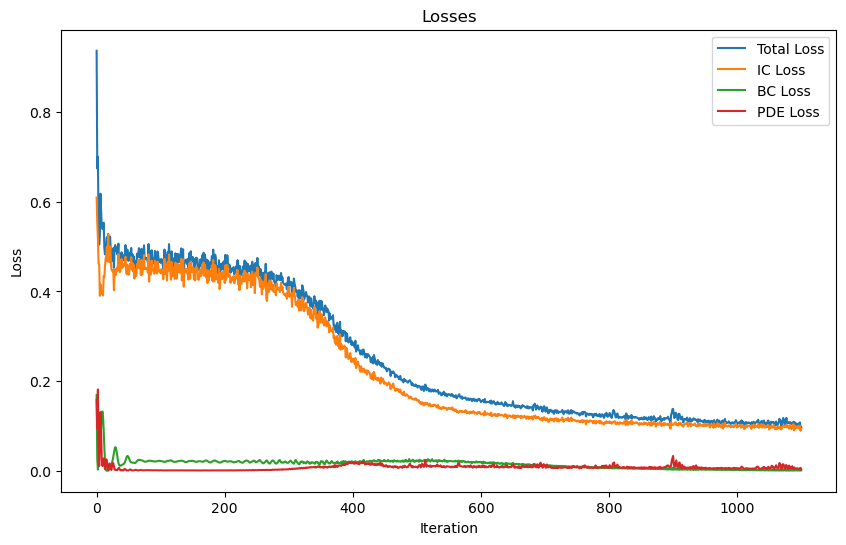

In [84]:
model = PINN()
num_iterations = 5000
num_points = 1000
loss_weights = {'ic': 1, 'bc': 10, 'pde': 100}
losses = train_PINN(model,num_iterations,num_points,loss_weights=loss_weights,patience=0.001)
plot_losses(losses)

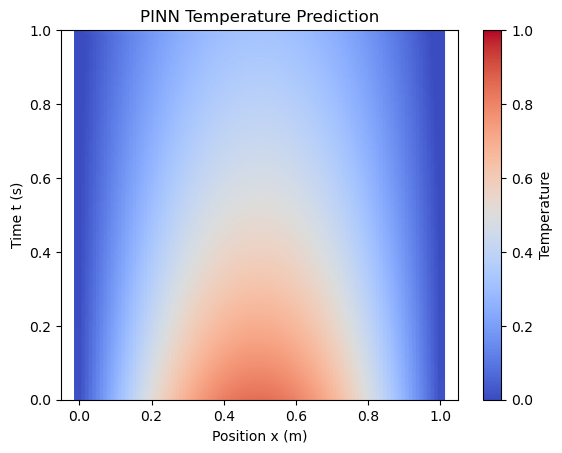

In [88]:
num_time_steps = 1000
x_plot = []
t_plot = []
u_pred = []
with torch.no_grad():
    x_vals = torch.linspace(0,1,100)
    for t in range(num_time_steps):
        t_val = torch.ones_like(x_vals) * t/num_time_steps
        input_data = torch.stack([x_vals.flatten(),t_val.flatten()], dim=1)
        solution = model(input_data)
        x_plot.append(x_vals)
        t_plot.append(t_val)
        u_pred.append(solution)

# Convert to numpy and flatten all arrays
x_plot = torch.cat(x_plot).numpy()
t_plot = torch.cat(t_plot).numpy()
u_pred_np = torch.cat(u_pred).numpy()

# Plot
plt.scatter(x_plot, t_plot, c=u_pred_np, cmap='coolwarm')
plt.clim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Position x (m)')
plt.ylabel('Time t (s)')
plt.title('PINN Temperature Prediction')
plt.colorbar(label='Temperature')
plt.show()